# 初始化fast_causal_inference

In [1]:
import fast_causal_inference
fast_causal_inference.set_config("conf.yaml")
sql_instance = fast_causal_inference.create()

# 模型使用示例

### 测试分布式数据集：test_data_small

测试数据表: test_data_small 是793200行的fake data

In [3]:
sql_instance.sql("desc test_data_small;")

,ttl_expression,default_type,name,default_expression,comment,type,codec_expression
0,,,treatment,,,UInt8,
1,,,numerator,,,Float64,
2,,,denominator,,,UInt8,
3,,,numerator_pre,,,Int64,
4,,,denominator_pre,,,UInt8,
5,,,y,,,Float64,
6,,,x1,,,Int32,
7,,,x2,,,Int32,
8,,,x3,,,Int32,
9,,,x3_string,,,String,


In [3]:
sql_instance.sql("select * from test_data_small limit 5;")

,x3_string,treatment,distance,weight,numerator,denominator,x8_needcut,denominator_pre,y,x1,x7_needcut,x2,x3,numerator_pre
0,0,0,0.0,0.1,0.0,1,0,1,0.0,-1,0,0,0,0
1,0,0,0.0,0.1,0.0,1,0,1,0.0,-1,0,0,0,0
2,0,0,0.0,0.1,0.0,1,0,1,0.0,-1,0,0,0,0
3,0,0,0.0,0.1,0.0,1,0,1,0.0,-1,0,0,0,0
4,0,0,0.0,0.1,0.0,1,0,1,0.0,-1,0,0,0,0


In [4]:
n = sql_instance.sql("select count(*) from test_data_small limit 1;")
print("数据表总样本量：",n)

数据表总样本量：   count()
0  793200


## 数据处理工具

### data split       

In [ ]:
把数据集按照给定比例分成训练集和测试集，并存入两张新的数据表

In [5]:
from fast_causal_inference.lib.tools import *
table = 'test_data_small'
data_split(table,0.5)

running, please wait
donetime cost: 0.4385105296969414 Seconds
running, please wait
donetime cost: 0.16524502635002136 Seconds
running, please wait
donetime cost: 0.1650787815451622 Seconds
running, please wait
donetime cost: 0.0038520097732543945 Seconds
table_train: test_data_small_1694705855_train
table_test: test_data_small_1694705855_test


('test_data_small_1694705855_train', 'test_data_small_1694705855_test')

### describe      

In [ ]:
对给定表中的数值型列进行描述性分析，包括均值、标准差、最大值、最小值、分位点、样本量

In [6]:
from fast_causal_inference.lib.tools import *
table = 'test_data_small'
X = 'y+x1+x2+x3'
describe(table,X)

,count,std,min,quantile_0.25,quantile_0.5,quantile_0.75,quantile_0.90,quantile_0.99,max
y,7.0,793200.0,4.9,1483.15,5925087.0,0.0,10.0,15654.840172,20.8
x1,5.0,793200.0,4.0,11.00,11.0,-1.0,7.0,2.202147,8.0
x2,2.0,793200.0,1.0,2.00,2.0,0.0,2.0,0.516766,2.0
x3,0.0,793200.0,0.0,3.00,3.0,0.0,0.0,0.559304,0.0


### histplot      

In [ ]:
把数据集按照给定比例分成训练集和测试集，并存入两张新的数据表

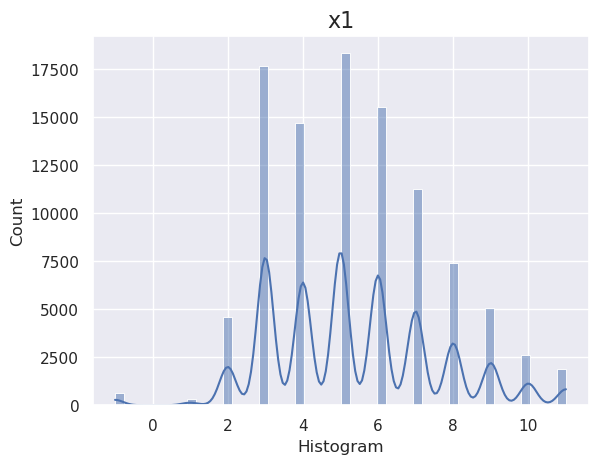

The type of x3_string is not numeric


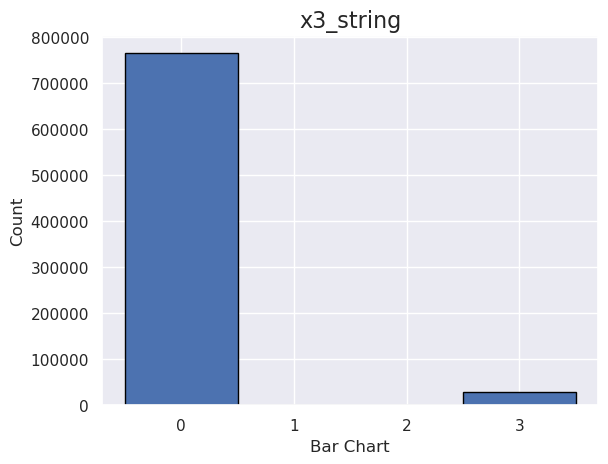

In [7]:
from fast_causal_inference.lib.tools import *
# 数值型的列，绘制直方图，并伴有KDE曲线
table = 'test_data_small'
col = 'x1'
histplot(table,col,bin_num=50)

# 字符型的列，绘制条形图
table = 'test_data_small'
col = 'x3_string'
histplot(table,col,bin_num=50)

### boxplot  

In [ ]:
把数据集按照给定比例分成训练集和测试集，并存入两张新的数据表

min: 5.0
25_quantile: 11.0
50_quantile: -1.0
75_quantile: 7.0
max: 4.0


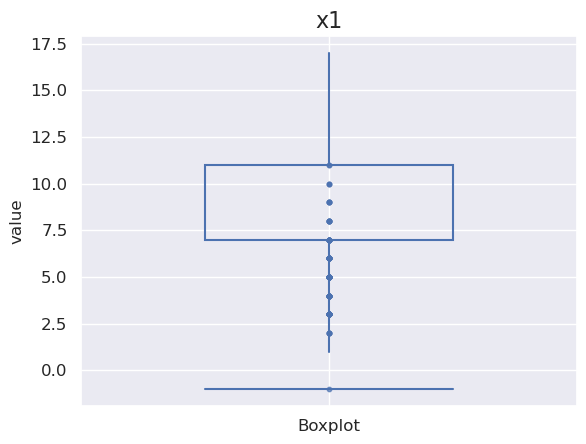

In [8]:
from fast_causal_inference.lib.tools import *
# col必须是数值型的列
table = 'test_data_small'
col = 'x1'
boxplot(table,col)

### ttest

#### ttest

做双样本t检验，关心的指标是 numerator/denominator，例如点击率指标，numerator代表点击，denominator代表曝光

In [5]:
ttest = sql_instance.sql("""select 
                                  ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided') as ttest_result
                            from 
                                  test_data_small""")
# 某个cell ttest结果转pandas
fast_causal_inference.to_pandas(ttest['ttest_result'][0])

,estimate,stderr,t-statistic,p-value,lower,upper
0,-50.589793,70.303156,-0.719595,0.471774,-188.381868,87.202282


#### ttest with CUPED

In [6]:
ttest = sql_instance.sql("""select 
                                  ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided',
                                  avg(numerator_pre)/avg(denominator_pre)) as ttest_result 
                            from 
                                  test_data_small""")
print(ttest)
# 某个cell ttest结果转pandas
fast_causal_inference.to_pandas(ttest['ttest_result'][0])

                                        ttest_result
0  estimate    stderr      t-statistic p-value   ...


,estimate,stderr,t-statistic,p-value,lower,upper
0,-50.900318,70.301131,-0.724033,0.469046,-188.688424,86.887788


#### 维度下钻的ttest

In [7]:
ttest = sql_instance.sql("""select 
                                  x2,ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided',
                                  avg(numerator_pre)/avg(denominator_pre)) as ttest_result 
                            from 
                                  test_data_small
                            group by 
                                  x2""")
print(ttest)
# 某个cell ttest结果转pandas
fast_causal_inference.to_pandas(ttest['ttest_result'][1])

  x2                                       ttest_result
0  0  estimate    stderr      t-statistic p-value   ...
1  2  estimate    stderr      t-statistic p-value   ...
2  1  estimate    stderr      t-statistic p-value   ...


,estimate,stderr,t-statistic,p-value,lower,upper
0,-214.165787,113.517865,-1.886626,0.059211,-436.658045,8.326471


### SRM

In [9]:
result = sql_instance.sql("""SELECT  
                                   SRM(x1, treatment, [1,1]) as srm
                            FROM  
                                   test_data_small""")
print(result)
fast_causal_inference.to_pandas(result['srm'][0])

                                                 srm
0  groupname   f_obs       ratio       chisquare ...


,groupname,f_obs,ratio,chisquare,p-value
0,0,2.124e+06,1.000000,0.087586,0.767268
1,1,2.124e+06,1.000000,None,None


### OLS

In [10]:
# ols
result = sql_instance.sql(f"""SELECT 
                                    ols(y~x1+x2) AS res
                              FROM
                                    test_data_small""")
print(result)
print("estimate", result.get_estimate())
print("stderr", result.get_stderr())
print("t_values", result.get_t_values())
print("pr", result.get_pr())
print("dml_summary", result.get_dml_summary())

Call:
lm(formula = y ~ + x1 + x2)

Coefficients:
		Estimate    Std. Error	t value	    Pr(>|t|)
(Intercept)	561.074807  68.150467   8.232883    0.0         
x1		-6.709481   7.984102    -0.840355   0.40071     
x2		-78.429634  34.023479   -2.305162   0.021158    

Residual standard error: 15654.799586 on 793197 degrees of freedom
Multiple R-squared: 8e-06, Adjusted R-squared: 5e-06
F-statistic: 3.056393 on 2 and 793197 DF,  p-value: 0.047058
estimate [561.074807, -6.709481, -78.429634]
stderr [68.150467, 7.984102, 34.023479]
t_values [8.232883, -0.840355, -2.305162]
pr [0.0, 0.40071, 0.021158]
dml_summary 		Coefficient Results
		Estimate    Std. Error	t value	    Pr(>|t|)
x0		561.074807  68.150467   8.232883    0.0         

		CATE Intercept Results
		Estimate    Std. Error	t value	    Pr(>|t|)
cate_intercept	-6.709481   7.984102    -0.840355   0.40071     



In [11]:
# predict
#写法1：只适用于在相同数据上做训练和预测
sql_instance.sql(f"""SELECT
                                    predict(olsState(y+x1+x2),x1,x2) AS res
                              FROM
                                    test_data_small
                              limit 10""")

,res
0,567.784288454952
1,567.784288454952
2,567.784288454952
3,567.784288454952
4,567.784288454952
5,567.784288454952
6,567.784288454952
7,567.784288454952
8,567.784288454952
9,567.784288454952


In [12]:
#写法2:适用于在相同或者不同数据集分别做训练和预测
sql_instance.sql(f"""WITH (
                                    SELECT
                                            OlsState(y,x1,x2) AS model
                                    FROM
                                            test_data_small
                                   ) AS model
                              SELECT
                                    evalMLMethod (model,x1,x2) AS y_pre
                              FROM
                                    test_data_small
                              limit 10""")

,y_pre
0,567.7842884540785
1,567.7842884540785
2,567.7842884540785
3,567.7842884540785
4,567.7842884540785
5,567.7842884540785
6,567.7842884540785
7,567.7842884540785
8,567.7842884540785
9,567.7842884540785


### WLS

In [13]:
result = sql_instance.sql(f"""SELECT
                                    wls(y~x1+x2,weight) as res
                              from 
                                    test_data_small""")
print(result)

Call:
lm(formula = y ~ + x1 + x2)

Coefficients:
		Estimate    Std. Error	t value	    Pr(>|t|)
(Intercept)	568.216     74.382803   7.639078    0.0         
x1		-6.907862   7.780073    -0.887892   0.374599    
x2		-89.265454  35.573033   -2.509357   0.012095    

Residual standard error: 13920.418759 on 793197 degrees of freedom
Multiple R-squared: 3.4e-05, Adjusted R-squared: 3.1e-05
F-statistic: 13.409511 on 2 and 793197 DF,  p-value: 2e-06


### Lasso

In [14]:
# 训练
ols = sql_instance.sql(f"""SELECT
                                stochasticLinearRegression(0.001, 0.1, 15, 'Lasso')(y, x1, x2, x3) as lasso
                           FROM
                                test_data_small""")
ols

,lasso
0,"[3020.1193124643564,989.4227585540596,2166.015..."


In [15]:
# 预测
ols = sql_instance.sql(f"""WITH (
                            SELECT
                                  stochasticLinearRegressionState(0.001, 0.1, 15, 'Lasso')(y, x1, x2, x3) AS model
                            FROM
                                  test_data_small
                            ) AS model
                            SELECT
                                   evalMLMethod(model,x1,x2,x3) AS y_pred
                            FROM
                                   test_data_small
                            limit 10""")
ols

,y_pred
0,-2295.9147494057374
1,-2295.9147494057374
2,-2295.9147494057374
3,-2295.9147494057374
4,-2295.9147494057374
5,-2295.9147494057374
6,-2295.9147494057374
7,-2295.9147494057374
8,-2295.9147494057374
9,-2295.9147494057374


### IV

这里的IV方程如下：  
$$Y = X3_{est} + X1 + X2$$
$$X3 = treatment+X1 + X2$$


In [21]:
# iv 
import time
t1=time.time()
iv = sql_instance.sql("""
                        SELECT
                              ivregression(y~(x3~treatment)+x1+x2)
                        FROM
                              test_data_small""")
t2=time.time()
print(iv,"用时：",t2-t1)

Call:
lm(formula = y ~ + x1 + x2 + x3)

Coefficients:
		Estimate    Std. Error	t value	    Pr(>|t|)
(Intercept)	1536.412812 177.922298  8.635302    0.0         
x1		-16480.0    1638.814621 -10.055263  0.0         
x2		175.048256  28030.0     0.006245    0.995018    
x3		-185.931709 311.361543  -0.597157   0.550403    

Residual standard error: 15654.804355 on 793196 degrees of freedom
Multiple R-squared: 8e-06, Adjusted R-squared: 5e-06
F-statistic: 2.209837 on 3 and 793196 DF,  p-value: 0.084693 用时： 0.2734560966491699


### matching

In [17]:
# propensitysocre 匹配
data = sql_instance.sql("""SELECT
                                 treatment,weight,caliperMatching(if(treatment=1,-1,1),weight,0.2) AS matchingIndex
                           FROM
                                 test_data_small
                           WHERE matchingIndex != 0
                           ORDER by abs(matchingIndex)
                           limit 50""")
data

,treatment,matchingIndex,weight
0,0,1,0.1
1,1,-1,0.1
2,0,2,0.1
3,1,-2,0.1
4,0,3,0.1
5,1,-3,0.1
6,1,-4,0.1
7,0,4,0.1
8,0,5,0.1
9,1,-5,0.1


In [19]:
# 精确匹配
data = sql_instance.sql("""SELECT
                                 treatment,x2,exactMatching(if(treatment=1,-1,1),x2) as matchingIndex
                           FROM
                                 test_data_small
                           WHERE matchingIndex != 0
                           ORDER by abs(matchingIndex)
                           limit 20""")
data

,treatment,matchingIndex,x2
0,1,-1,0
1,0,1,0
2,1,-2,0
3,0,2,0
4,1,-3,0
5,0,3,0
6,1,-4,0
7,0,4,0
8,1,-5,0
9,0,5,0


### Uplift模型

#### causal tree

****STEP1.  Table check.
debug
****STEP2.  Bucket the continuous variables(cut_x_names).
****STEP3.  Create new table for training causaltree:  test_data_small_1694705096_new .
running, please wait
donetime cost: 0.3903878331184387 Seconds
	 train data samples: 396630,predict data samples: 396570
****STEP4.  Build tree.
================================== start buildTree -- maxDepth: 2, nodePosition: root==================================
--------start leftNode - build -- depth: 0, nodePosition: LL--------
no split points that satisfy the condition,stop splitting as a leaf node
--------start rightNode - build -- depth: 0, nodePosition: LR--------
no split points that satisfy the condition,stop splitting as a leaf node
============================================== build Tree Sucessfully=====================================================
****STEP5.  Estimate CATE.
============================================== compute Tree Sucessfully====================================================

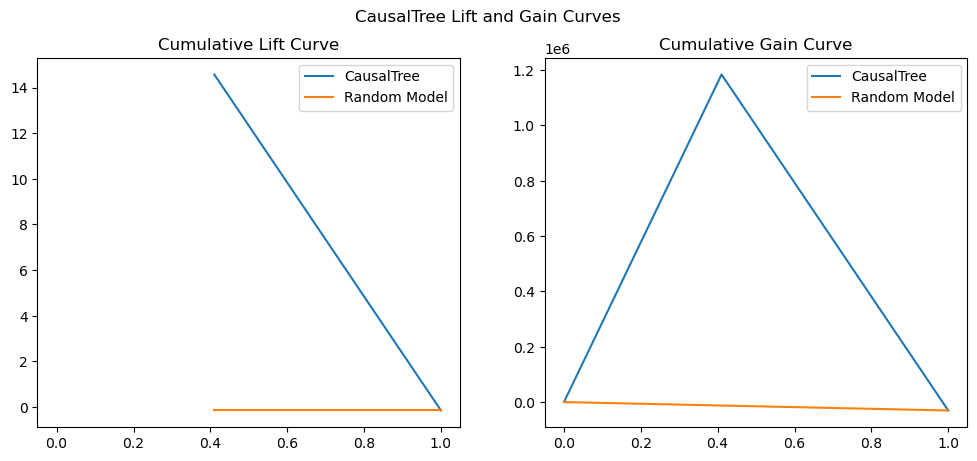

running, please wait
donetime cost: 0.004571244120597839 Seconds
running, please wait
donetime cost: 0.3350541666150093 Seconds
running, please wait
donetime cost: 0.3520631864666939 Seconds
running, please wait
donetime cost: 0.003965400159358978 Seconds


In [4]:
from fast_causal_inference.lib.causaltree import CausalTree
Y='y'
T='treatment'
table = 'test_data_small'
X = 'x1+x2+x7_needcut+x8_needcut'
needcut_X = 'x7_needcut+x8_needcut'

hte = CausalTree(depth = 2)
hte.fit(Y,T,X,needcut_X,table)

# 输出树结构的图（可下载）
treeplot = hte.treeplot()
treeplot.render('digraph.gv', view=False) # 可以在digraph.gv.pdf文件里查看tree的完整图片并下载

# 输出训练集上的uplift curve
hte.hte_plot() 
# 输出变量重要性
hte.feature_importance 
fast_causal_inference.clickhouse_drop_view(clickhouse_view_name="test_table_small_causaltree_dep2") 
hte.effect_2_clickhouse(table_output='test_table_small_causaltree_dep2') # 指定一张带预测的表，预测该表的HTE

In [5]:
hte.feature_importance 

,featName,importance
0,x1,3.900502e+09


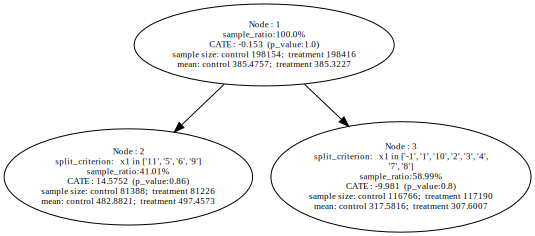

In [6]:
treeplot

### DML

#### LinearDML  

In [ ]:
from fast_causal_inference.lib.linear_dml import *


Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x7_needcut'
model = LinearDML(Y=Y,T=T,X=X_fordml,W=W, model_y="ols", model_t="stochasticLogisticRegression(1.0, 1.0, 10, 'SGD')", cv=2, table=table)


print(model.summary())
print(model.ate('x1+x2',0,1))
print(model.ate_interval('x1+x2',0,1,alpha=0.05))
print(model.effect('x1+x2',0,1))
clickhouse_drop_view(clickhouse_view_name="test_table_output1") 
model.effect('x1+x2',0,1,table_output='test_table_output1') # effect预测结果存到表里
print(model.effect_interval('x2+x3',0,1,0.05))
clickhouse_drop_view(clickhouse_view_name="test_table_output2") 
model.effect_interval('x1+x2',0,1,0.05,table_output='test_table_output2') # effect预测结果存到表里

#### LinearDML (T进行treatment_featurizer)

In [ ]:
Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x7_needcut'
model = LinearDML(Y=Y,T=T,X=X_fordml,W=W, model_y="ols", model_t="ols", cv=2, table=table, treatment_featurizer=PolynomialFeatures('rand()', 3))
print('\n----summary----')
print(model.summary())
print(model.effect(T0=0.1, T1=0.2))
print(model.const_marginal_effect())
print(model.marginal_effect())
print(model.marginal_ate())

#### NonparamDML

In [ ]:

from fast_causal_inference.lib.linear_dml import NonParamDML

Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x7_needcut'

model = NonParamDML(table=table, Y=Y,T=T,X=X_fordml, model_y='Ols', model_t='Ols', cv=2)
print('\n----summary----')
print(model.summary())

### Uplift模型评估

这里是对比了用causaltree 不同深度的模型，在预测集上的uplift curve

In [ ]:
from fast_causal_inference.lib.metrics import *
tmp1 = get_lift_gain("effect", "y", "treatment", "test_table_small_causaltree_dep3",discrete_treatment=False, K=100)
tmp1.summary()
tmp2 = get_lift_gain("effect", "y", "treatment", "test_table_small_causaltree_dep2",discrete_treatment=False, K=100)
tmp2.summary()
hte_plot([tmp1, tmp2])